# Proof of concept for using transpilation to insert arbitrary X-Gates
- transpilation example taken from ibm_challenge 2024 lab1

In [1]:
# Imports

from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import XGate, YGate
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOsaka
from qiskit.transpiler import InstructionProperties, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.transpiler.passes.scheduling import ASAPScheduleAnalysis,PadDynamicalDecoupling
from qiskit.visualization.timeline import draw, IQXStandard
from qiskit.transpiler import StagedPassManager
from qiskit.visualization import plot_circuit_layout

from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.dagcircuit import DAGCircuit

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

from qiskit.visualization import plot_histogram

## define hw to run (fake backend

In [2]:
#define coupling map
coupling_map = [[0,1],[1,0],[1,2],[2,1],[0,2],[2,0],[2,3],[3,2],[2,4],[4,2],[3,4],[4,3]]

In [3]:
fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"],
    coupling_map = coupling_map
  )

## define experiment

In [4]:
qc = QuantumCircuit(5,5)
qc.h(0)
qc.cx(0,1)
qc.x(1)
qc.cx(0,2)
qc.measure_all()

## use standard transpiler run on hardware an plot results

In [5]:
pm = generate_preset_pass_manager(optimization_level=0, backend=fake_backend, seed_transpiler=0)
qc_isa = pm.run(qc)

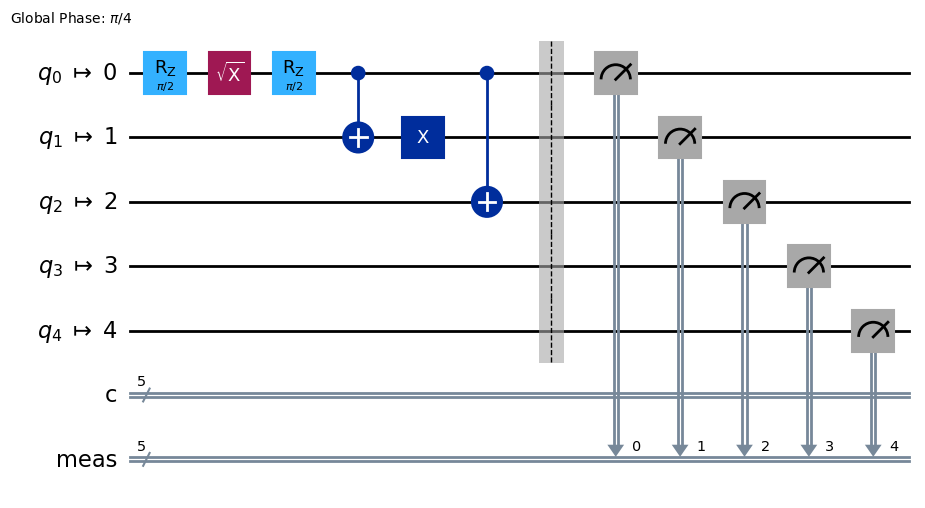

In [6]:
qc_isa.draw("mpl")

In [7]:
# run on fake backend
sampler = Sampler(fake_backend)
pub = (qc_isa)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'00010': 474, '00111': 6, '00101': 507, '00100': 6, '00110': 3, '00001': 4}


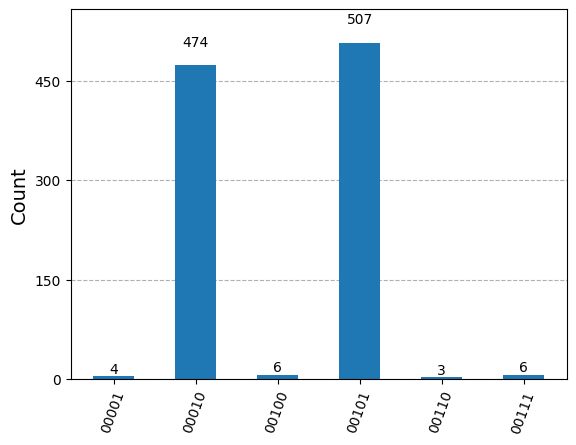

In [8]:
# plot results
plot_histogram(counts_sampler)

## now try to temper transplier

In [9]:
# create tempered transpiler

In [10]:
class AddXGateOptimizer(TransformationPass): 
    def replacement_cirq(self):
        qc = QuantumCircuit(1)
        qc.x(0)
        qc.x(0)
        return qc
        
    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:
        for node in dag.op_nodes():
            #print(node.op.name)
            if node.op.name == 'x':
                replacement_circ = self.replacement_cirq()
                replacement_dag = circuit_to_dag(replacement_circ)
                # substitute gate to twirl node with twirling mini-DAG
                dag.substitute_node_with_dag(node, replacement_dag)
        #for node in dag.op_nodes():
        #    print("after", node.op)
        return dag

In [11]:
pm_opt = PassManager([AddXGateOptimizer()])
qc_isa_tempered = pm_opt.run(qc_isa)

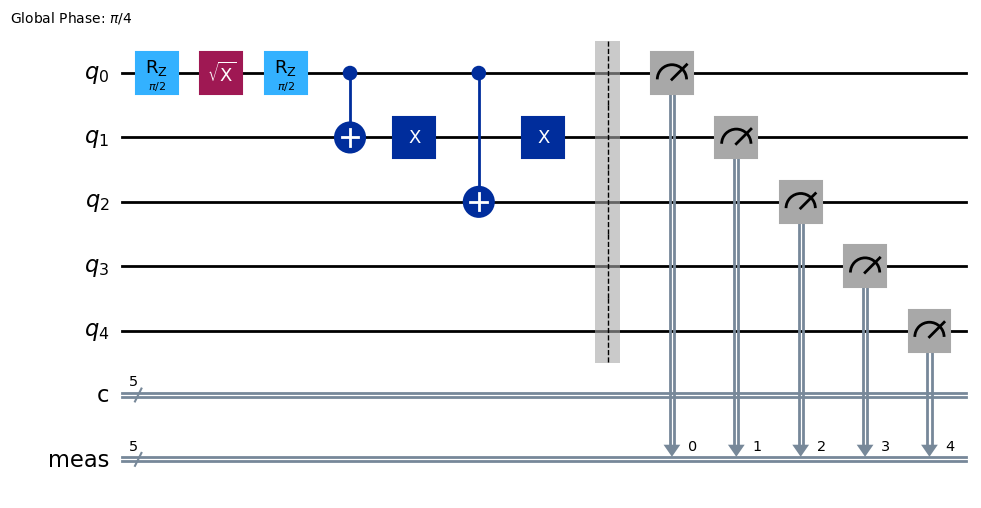

In [12]:
qc_isa_tempered.draw("mpl")

In [13]:
# run on fake backend
sampler = Sampler(fake_backend)
pub = (qc_isa_tempered)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'00000': 499, '00111': 474, '00011': 5, '10111': 1, '00101': 9, '00100': 3, '01111': 2, '00010': 3, '00001': 1, '00110': 3}


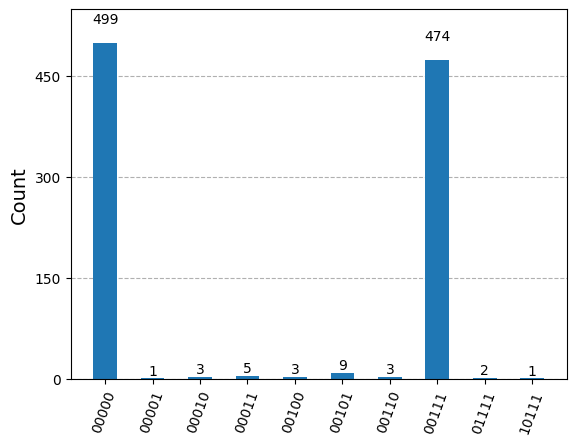

In [14]:
# plot results
plot_histogram(counts_sampler)

## now check if qc_isa and qc_isa_tempered are equivalent

In [15]:
qc_isa.remove_final_measurements()
qc_isa_tempered.remove_final_measurements()

qc_combined = qc_isa.compose(qc_isa_tempered.inverse())
qc_combined.measure_all()

In [16]:
qc_combined_isa = pm.run(qc_combined)

In [17]:
# run on fake backend
sampler = Sampler(fake_backend)
pub = (qc_combined_isa)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'00010': 968, '00011': 8, '00001': 5, '00000': 9, '00110': 7, '00111': 2, '00101': 1}


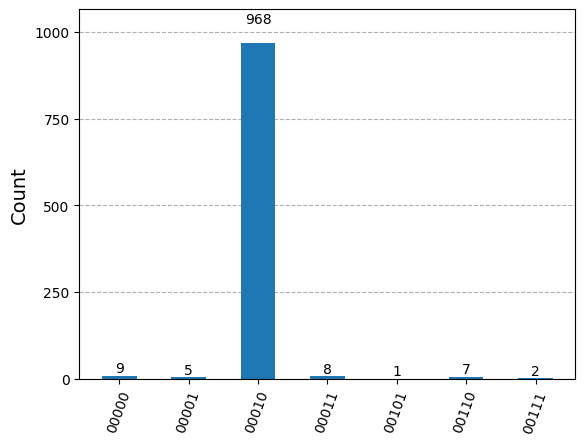

In [18]:
# plot results -> should yield |00000> if equivalent
plot_histogram(counts_sampler)